<a href="https://colab.research.google.com/github/tanmayg/LS/blob/master/diag_pred_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
PROJECT_ID = "lucid-sonar-139519"

In [2]:
import sys, os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
  !pip install witwidget --quiet
  !pip install tensorflow==1.15.0 --quiet
  !gcloud config set project $PROJECT_ID

elif "DL_PATH" in os.environ:
  !sudo pip install tabulate --quiet

Updated property [core/project].


In [0]:
BUCKET_NAME = "lsattentionmodel"
REGION = "us-central1"

In [4]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import json
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

# Should be 1.15.0
print(tf.__version__)

1.15.0


In [5]:
pwd

'/content'

In [6]:
# Copy the data to your notebook instance
!gsutil cp 'gs://lsattentionmodel/HT_Pros_test_data_2020Jan29_0445_sample.csv' ./

Copying gs://lsattentionmodel/HT_Pros_test_data_2020Jan29_0445_sample.csv...
- [1 files][234.9 MiB/234.9 MiB]                                                
Operation completed over 1 objects/234.9 MiB.                                    


In [7]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

def preprocess_data(datafile, batch_size, maxlen, scaler=None):
    """ Preprocessing data and getting a sequence of word indices """
    df = pd.read_csv(datafile)
    ID = list(set(list(df.patient_id)))
    mf = (len(ID)//batch_size)*batch_size
    ID = ID[:mf]
    print("\nDataset patient count:", len(ID))
    df = df.set_index(['patient_id', 'abs_time'])
    df = df.iloc[df.index.get_level_values('patient_id').isin(ID)]
    
    #create the input & output sets for train data
    X = df.drop(['hadm_id','admittime','dischtime','charttime_hr','Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y','clm_pymt_amt_y','cum_clm_pymt_amt_y'],axis=1)
    #drop rolling mean columns
    X = X[X.columns.drop(list(X.filter(regex='_amt_rm_')))]
    #drop rolling std columns
    X = X[X.columns.drop(list(X.filter(regex='_amt_rs_')))]
    #define StdScaler Scaler for input variables
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(X[X.columns])
    X[X.columns] = scaler.transform(X[X.columns])
    #define output labels
    #Y1 = df[['Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y']]
    Y1 = df[['Hypertension_y']]
    Y1 = Y1.astype(int)
    
    # train data #
    X = [X.loc[patient].values for patient in ID]
    Y1 = [Y1.loc[patient].values for patient in ID]
    
    X = sequence.pad_sequences(X, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    Y1 = sequence.pad_sequences(Y1, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    
    return(X, Y1, ID, scaler)

Using TensorFlow backend.


In [8]:
batch_size=128
maxlen=31
ts_in_seq, ts_out_seq, ts_ID, scaler = preprocess_data('HT_Pros_test_data_2020Jan29_0445_sample.csv', 
                                                       batch_size=batch_size, maxlen=maxlen, scaler=None)


Dataset patient count: 6144


In [9]:
ts_in_seq.shape, ts_out_seq.shape

((6144, 31, 1771), (6144, 31, 1))

In [0]:
from tensorflow.keras.layers import Input, Bidirectional, CuDNNLSTM, TimeDistributed, Dense, LSTM
from tensorflow.keras.models import Model

In [11]:
input_layer = Input(batch_shape=(batch_size, maxlen, ts_in_seq.shape[-1]))
x = Bidirectional(LSTM(512, batch_size=batch_size, return_sequences=True, stateful=True))(input_layer)
x = Bidirectional(LSTM(512, batch_size=batch_size, return_sequences=True, stateful=True))(x)
output1 = TimeDistributed(Dense(1, activation='sigmoid'), name='output1')(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model_builtin = Model(outputs=output1, inputs=input_layer, name='builtin_predict')

In [13]:
optimizer = tf.keras.optimizers.Adam(lr=0.0002)
model_builtin.compile(optimizer = optimizer, loss={'output1': 'binary_crossentropy'}, metrics=['accuracy', 'mse'])
model_builtin.summary()

Model: "builtin_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 31, 1771)]         0         
_________________________________________________________________
bidirectional (Bidirectional (128, 31, 1024)           9355264   
_________________________________________________________________
bidirectional_1 (Bidirection (128, 31, 1024)           6295552   
_________________________________________________________________
output1 (TimeDistributed)    (128, 31, 1)              1025      
Total params: 15,651,841
Trainable params: 15,651,841
Non-trainable params: 0
_________________________________________________________________


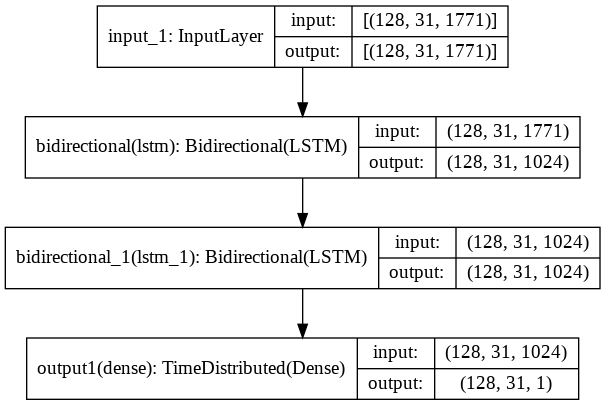

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model_builtin, show_shapes=True, show_layer_names=True)

In [16]:
model_builtin.fit(ts_in_seq, ts_out_seq, batch_size=128, shuffle=False, epochs=1, verbose=1)

Train on 6144 samples
6144/6144 [==============================] - 483s 79ms/sample - loss: 0.1620 - acc: 0.9700 - mean_squared_error: 0.0346


In [17]:
results = model_builtin.evaluate(ts_in_seq, ts_out_seq)
print(results)

6144/6144 [==============================] - 137s 22ms/sample - loss: 0.0920 - acc: 0.9721 - mean_squared_error: 0.0242
[0.09197703485066692, 0.972147, 0.024152938]


In [0]:
predict = model_builtin.predict(ts_in_seq[:128])

In [21]:
# Preview predictions on the first 5 examples from our test dataset
for i, val in enumerate(predict):
  print('Predicted duration: {}'.format(val))
  print('Actual duration: {} \n'.format(ts_out_seq[i]))

Predicted duration: [[0.04501367]
 [0.08393571]
 [0.14255396]
 [0.19087505]
 [0.23388955]
 [0.21107283]
 [0.15681109]
 [0.07543233]
 [0.04703981]
 [0.03040436]
 [0.02086431]
 [0.01524511]
 [0.01181436]
 [0.00963861]
 [0.00820553]
 [0.00722471]
 [0.00652519]
 [0.00600258]
 [0.00559244]
 [0.00525597]
 [0.00497299]
 [0.00473768]
 [0.00455654]
 [0.00444645]
 [0.00443387]
 [0.00455546]
 [0.00486067]
 [0.00541845]
 [0.00633791]
 [0.00782999]
 [0.01043949]]
Actual duration: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted duration: [[0.03206068]
 [0.02836874]
 [0.01569477]
 [0.01321021]
 [0.01123613]
 [0.00980783]
 [0.00876069]
 [0.00798002]
 [0.00738427]
 [0.00691476]
 [0.00652817]
 [0.00619167]
 [0.00588068]
 [0.0055767 ]
 [0.00526673]
 [0.0049434 ]
 [0.00460413]
 [0.00425148]
 [0.0038926 ]
 [0.00353831]
 [0.00320202]
 [0.0028984 ]
 [0.0026429

In [22]:
## Convert our Keras model to an estimator
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model_builtin, model_dir='export')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'export', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8820d247f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# We need this serving input function to export our model in the next cell
serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_1': model_builtin.input},
    default_batch_size=128
)

In [26]:
export_path = keras_estimator.export_saved_model(
  'gs://' + BUCKET_NAME + '/explanations',
  serving_input_receiver_fn=serving_fn
).decode('utf-8')
print(export_path)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from export/keras/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://lsattentionmodel/explanations/temp-b'1581675211'/saved_model.pb
gs://lsattentionmodel/explanations/1581675211


In [27]:
!saved_model_cli show --dir $export_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (128, 31, 1771)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output1'] tensor_info:
        dtype: DT_FLOAT
        shape: (128, 31, 1)
        name: output1/Reshape_1:0
  Method name is: tensorflow/serving/predict


In [28]:
# Print the names of our tensors
print('Model input tensor: ', model_builtin.input.name)
print('Model output tensor: ', model_builtin.output.name)

Model input tensor:  input_1:0
Model output tensor:  output1/Reshape_1:0


In [0]:
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": model_builtin.input.name,
        #"input_baselines": [pd.DataFrame(ts_in_seq).median().values.tolist()]
      }
    },
    "outputs": {
      "duration": {
        "output_tensor_name": model_builtin.output.name
      }
    },
  "framework": "tensorflow"
  }

In [0]:
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [33]:
!gsutil cp explanation_metadata.json $export_path

Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][  155.0 B/  155.0 B]                                                
Operation completed over 1 objects/155.0 B.                                      


In [0]:
MODEL = 'builtin_bike'

In [37]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/lucid-sonar-139519/models/builtin_bike].


In [0]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [39]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.


In [40]:
# Make sure the model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $VERSION --model $MODEL

createTime: '2020-02-14T10:17:21Z'
deploymentUri: gs://lsattentionmodel/explanations/1581675211
etag: 3dQMH3VXZQM=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/lucid-sonar-139519/models/builtin_bike/versions/v1
pythonVersion: '3.7'
runtimeVersion: '1.15'
state: READY


In [0]:
# Format data for prediction to our model
prediction_json = {'input_1': ts_in_seq[0][0].tolist()}
with open('builtin-data.txt', 'a') as outfile:
  json.dump(prediction_json, outfile)

In [53]:
len(ts_in_seq[0][0].tolist()), ts_in_seq[0].shape

(1771, (31, 1771))

In [55]:
# Preview the contents of the data file
!cat builtin-data.txt

{"input_1": {"input_1": {"input_1": [[1.376764178276062, 0.18412573635578156, 1.7717645168304443, 0.8463374972343445, -0.8463374972343445, -0.015336207114160061, -0.3432675302028656, -0.1351509392261505, -0.2040562778711319, 0.44220149517059326, -0.2760586440563202, 0.2760586440563202, -0.045684244483709335, -0.15788234770298004, -0.04341309517621994, -0.05949490889906883, -0.06947547197341919, -0.04958067834377289, -0.06873936206102371, 0.0, -0.06145332753658295, -0.10748594999313354, -0.043799735605716705, -0.05598076060414314, -0.06947547197341919, -0.11032821983098984, -0.03933984041213989, -0.14596253633499146, -0.07711908221244812, -0.11536584794521332, -0.07578546553850174, -0.016395369544625282, -0.05445052683353424, -0.0617281049489975, -0.192527174949646, -0.07351028919219971, 0.0, -0.05445052683353424, -0.08469109982252121, -0.08203531801700592, -0.10732594132423401, -0.0617281049489975, -0.06227407231926918, 0.0, -0.04493984952569008, -0.008196858689188957, -0.0589235797524

In [46]:
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='builtin-data.txt'
response = json.loads(resp_obj.s)

JSONDecodeError: ignored

In [56]:
!gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='builtin-data.txt'

ERROR: (gcloud.beta.ai-platform.explain) Input instances are not in JSON format. See "gcloud ml-engine predict --help" for details.


In [58]:
!gcloud ml-engine predict --help

NAME
    gcloud ml-engine predict - run AI Platform online prediction

SYNOPSIS
    gcloud ml-engine predict --model=MODEL
        (--json-instances=JSON_INSTANCES | --text-instances=TEXT_INSTANCES)
        [--signature-name=SIGNATURE_NAME] [--version=VERSION]
        [GCLOUD_WIDE_FLAG ...]

DESCRIPTION
    gcloud ml-engine predict sends a prediction request to AI Platform for the
    given instances. This command will read up to 100 instances, though the
    service itself will accept instances up to the payload limit size
    (currently, 1.5MB). If you are predicting on more instances, you should use
    batch prediction via

        $ gcloud ml-engine jobs submit prediction.

REQUIRED FLAGS
     --model=MODEL
        Name of the model.

     Exactly one of these must be specified:

       --json-instances=JSON_INSTANCES
          Path to a local file from which instances are read. Instances are in
          JSON format; newline delimited.

          An example of the JSON instances 